<a href="https://colab.research.google.com/github/XuZhaozhong-1/Xzz/blob/main/Lab_427_Zhaozhong_Xu4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 4 Report: 
## Surpass Human Performance in Fashion MNIST Classificaion

### Name

In [899]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import numpy as np
from sklearn.preprocessing import StandardScaler

In [900]:
from IPython.display import Image # For displaying images in colab jupyter cell

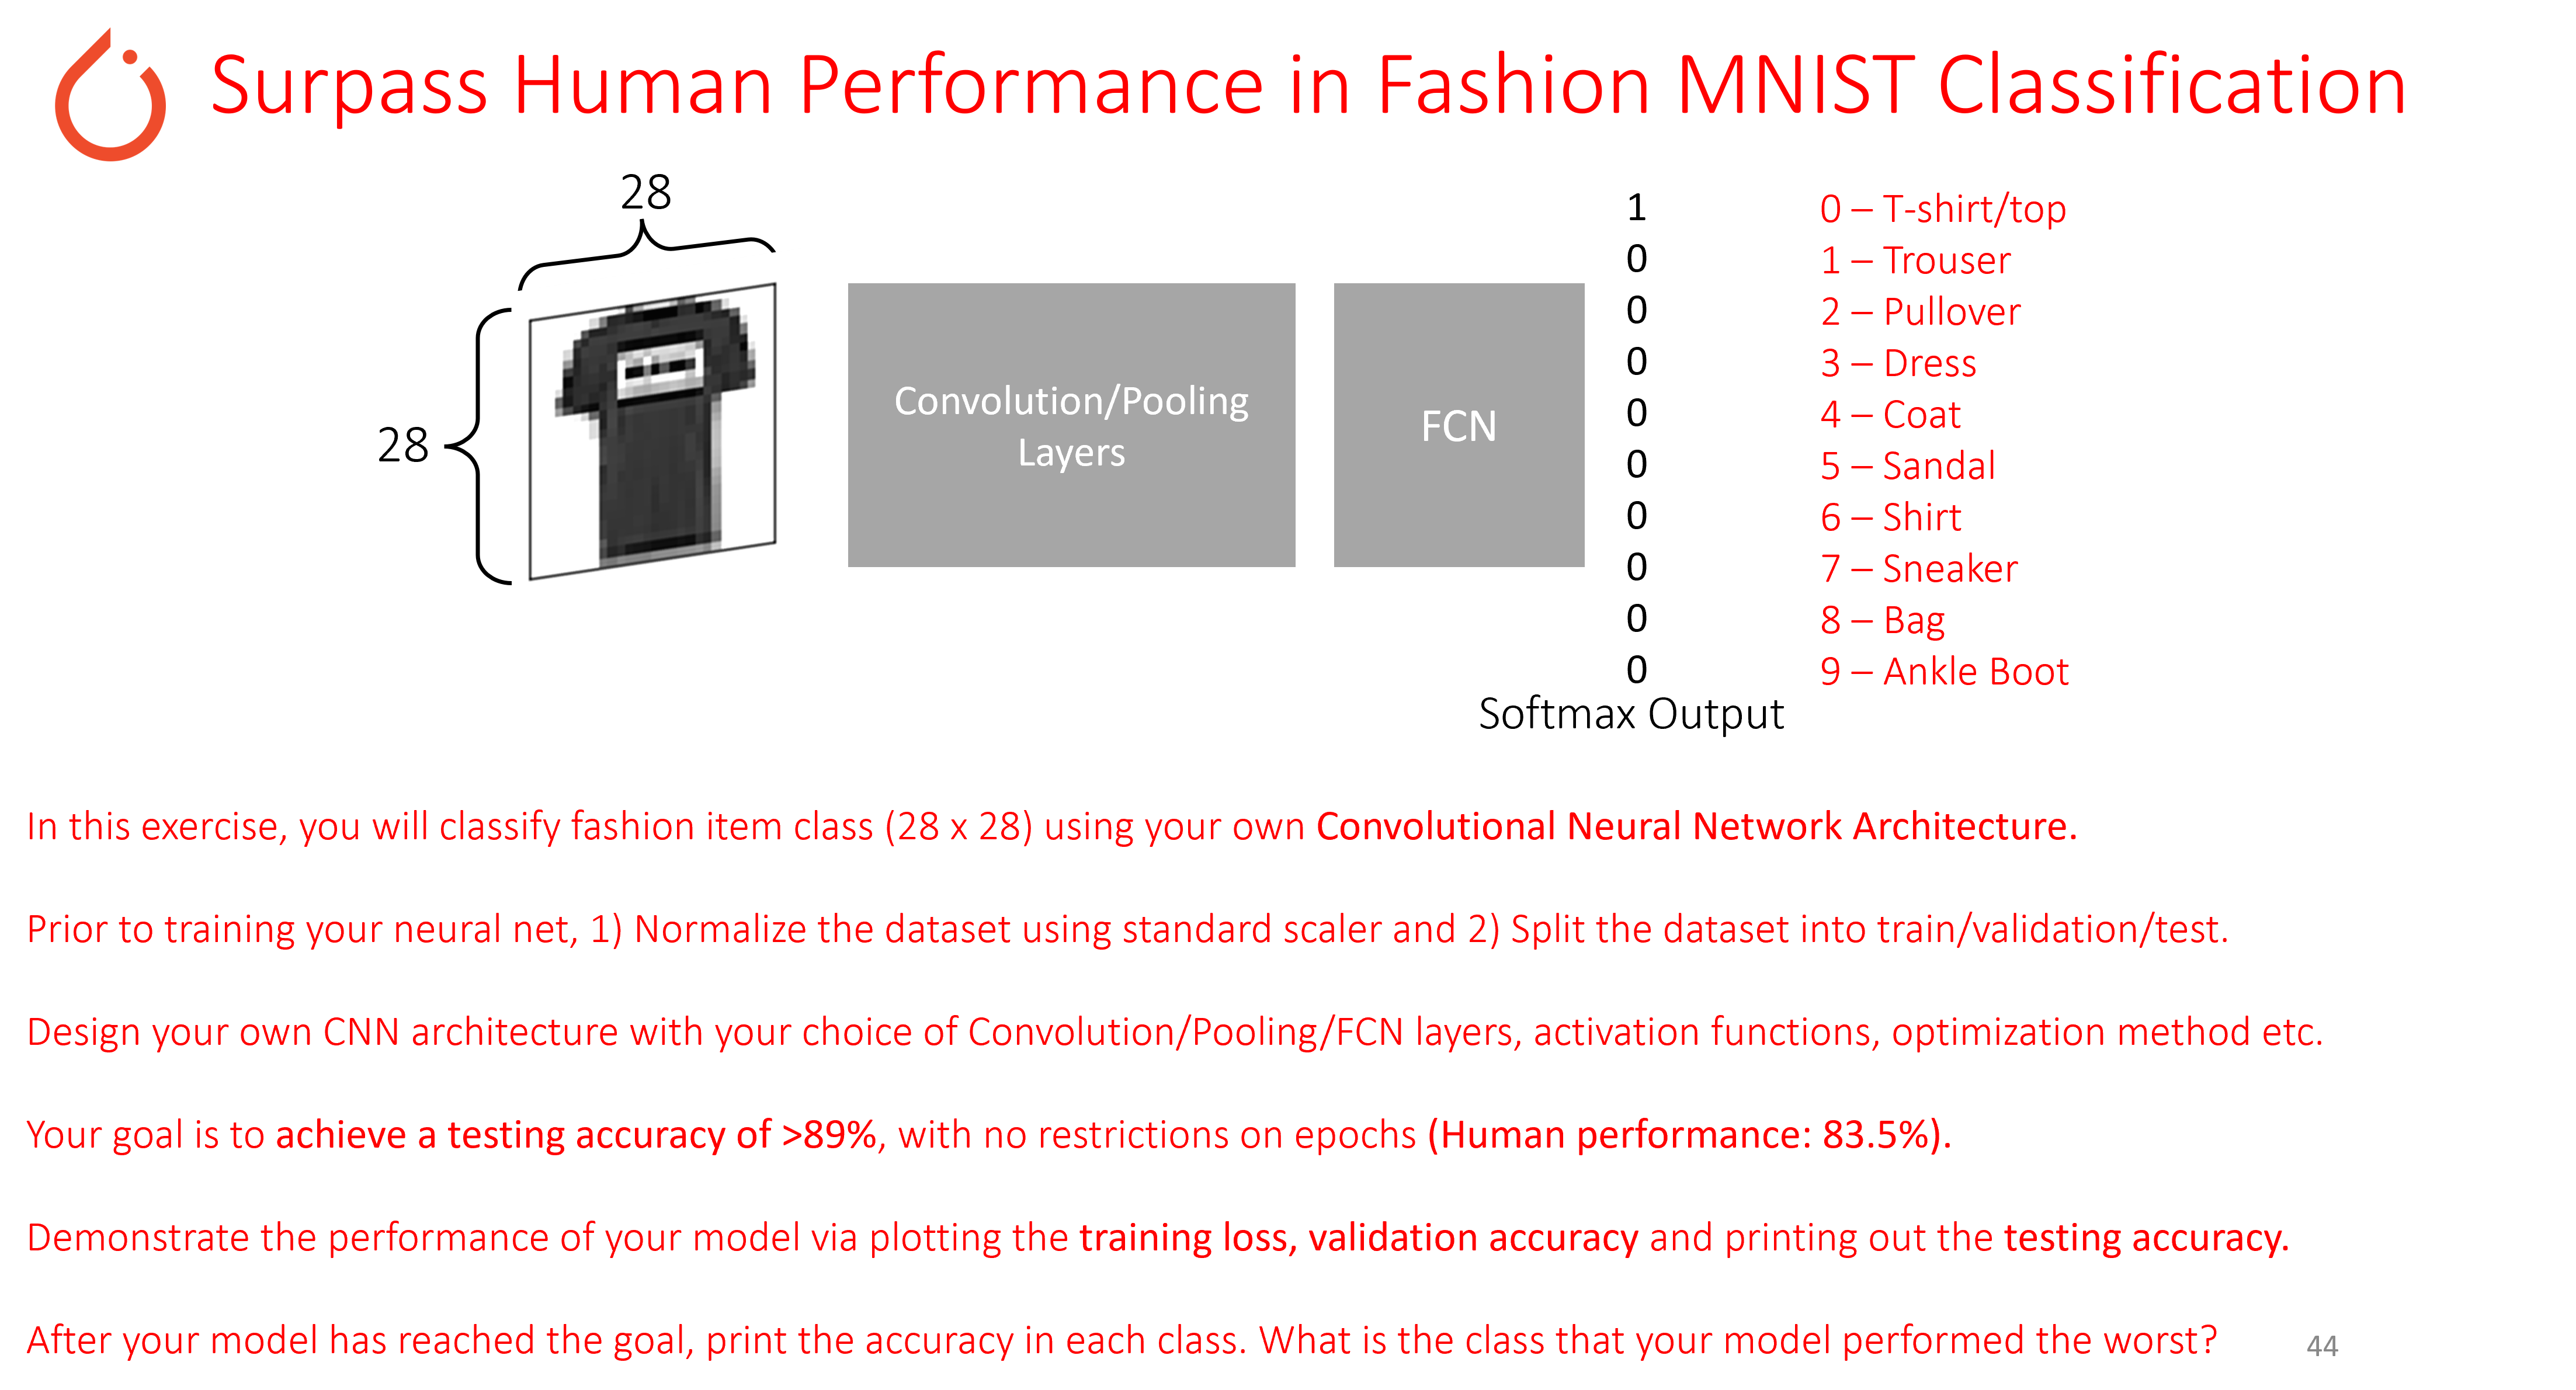

In [901]:
Image('lab4_exercise.png', width = 1000)

### Prepare Data

In [902]:
# Load Fashion-MNIST Dataset in Numpy

# 10000 training features/targets where each feature is a greyscale image with shape (28, 28)
train_features = np.load('fashion_mnist_train_features.npy') 
train_targets = np.load('fashion_mnist_train_targets.npy')

# 1000 testing features/targets 
test_features = np.load('fashion_mnist_test_features.npy')
test_targets = np.load('fashion_mnist_test_targets.npy')

# Let's see the shapes of training/testing datasets
print("Training Features Shape: ", train_features.shape)
print("Training Targets Shape: ", train_targets.shape)
print("Testing Features Shape: ", test_features.shape)
print("Testing Targets Shape: ", test_targets.shape)

Training Features Shape:  (10000, 28, 28)
Training Targets Shape:  (10000,)
Testing Features Shape:  (1000, 28, 28)
Testing Targets Shape:  (1000,)


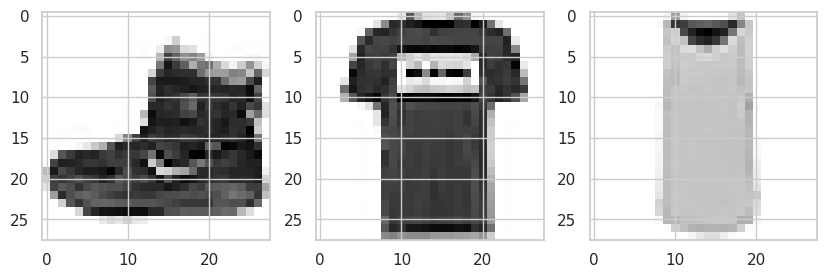

In [903]:
# Visualizing the first three training features (samples)

plt.figure(figsize = (10, 10))

plt.subplot(1,3,1)
plt.imshow(train_features[0], cmap = 'Greys')

plt.subplot(1,3,2)
plt.imshow(train_features[1], cmap = 'Greys')

plt.subplot(1,3,3)
plt.imshow(train_features[2], cmap = 'Greys')

In [904]:
# Perform standard scaling on the training and testing features
# After scaling, make sure you reshape the training features back to (10000, 28, 28) and testing features to (1000, 28, 28)
# since CNNs take 2D tensors as inputs

train_features = train_features.reshape((10000,28*28))
test_features = test_features.reshape((1000,28*28))

scaler=StandardScaler()
train_features=scaler.fit_transform(train_features).reshape(10000,28,28)
test_features=scaler.fit_transform(test_features).reshape(1000,28,28)

print(train_features.shape,test_features.shape)

(10000, 28, 28) (1000, 28, 28)


In [905]:
# Take the first 1000 (or randomly select 1000) training features and targets as validation set 

validation_features = train_features[:1000]
validation_targets = train_targets[:1000]

# Take the remaining 9000 training features and targets as training set 

train_features = train_features[1000:]
train_targets = train_targets[1000:]

print(validation_features.shape,train_features.shape)

(1000, 28, 28) (9000, 28, 28)


In [906]:
# Reshape train/validation/test sets to conform to PyTorch's (N, Channels, Height, Width) standard for CNNs

train_features = train_features.reshape((9000,1,28,28))
validation_features = validation_features.reshape((1000,1,28,28))
test_features = test_features.reshape(1000,1,28,28)

### Define Model

In [907]:
# Define your CNN architecture here

class CNNModel(torch.nn.Module):
    
    def __init__(self):
        
        super(CNNModel, self).__init__()
        
        self.cnn1 = torch.nn.Conv2d(in_channels=1,out_channels=16,kernel_size=5,stride=1,padding=2)
        self.maxpool1 = torch.nn.MaxPool2d(kernel_size=2)
        self.cnn2 = torch.nn.Conv2d(in_channels=16,out_channels=32,kernel_size=5,stride=1,padding=2)
        self.maxpool2 = torch.nn.MaxPool2d(kernel_size=2)
        self.fc1 = torch.nn.Linear(32*7*7,10)
    def forward(self, x):
        conv1_out = torch.nn.functional.relu(self.cnn1(x))
        pool1_out = self.maxpool1(conv1_out)
        
        conv2_out = torch.nn.functional.relu(self.cnn2(pool1_out))
        pool2_out = self.maxpool2(conv2_out)

        fc1_input = pool2_out.view(pool2_out.size(0),-1)
        out = self.fc1(fc1_input)
        # Note: If you are using CrossEntropyLoss() do NOT apply softmax to the final ouput 
        # since it's incorporated within the loss function
        
        return out

### Select Hyperparameters

In [908]:
# Fix the random seed so that model performance is reproducible
torch.manual_seed(55)

# Initialize your CNN model

model = CNNModel()

# Define learning rate, epoch and batchsize for mini-batch gradient

learning_rate = 0.0033
epochs = 100
batchsize = 1000

# Define loss function and optimizer

loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)


model

CNNModel(
  (cnn1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=10, bias=True)
)

### Identify Tracked Values

In [909]:
# Placeholders for training loss and validation accuracy during training
# Training loss should be tracked for each iteration (1 iteration -> single forward pass to the network)
# Validation accuracy should be evaluated every 'Epoch' (1 epoch -> full training dataset)
# If using batch gradient, 1 iteration = 1 epoch

train_loss_list = []
validation_accuracy_list = np.zeros((epochs,))

### Train Model

In [910]:
import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = model.to(device)

train_inputs = torch.from_numpy(train_features).float().to(device)
train_targets = torch.from_numpy(train_targets).long().to(device)

validation_inputs = torch.from_numpy(validation_features).float().to(device)
validation_targets = torch.from_numpy(validation_targets).long().to(device)

test_inputs = torch.from_numpy(test_features).float().to(device)
test_targets = torch.from_numpy(test_targets).long().to(device)

train_batches_features = torch.split(train_inputs, batchsize)
train_batches_targets = torch.split(train_targets, batchsize)

# Create new lists to store the GPU-converted batches
train_batches_features_gpu = []
train_batches_targets_gpu = []

batch_split_num = len(train_batches_features)

for i in range(batch_split_num):
    train_batches_features_gpu.append(train_batches_features[i].to(device))
    train_batches_targets_gpu.append(train_batches_targets[i].to(device))

for epoch in tqdm.trange(epochs):
    for i in range(batch_split_num):   
        optimizer.zero_grad()
    
        train_outputs = model(train_batches_features_gpu[i])
    
        loss = loss_func(train_outputs, train_batches_targets_gpu[i])
    
        train_loss_list.append(loss.item())
    
        loss.backward()
    
        optimizer.step()
    
    with torch.no_grad():        
        validation_outputs = model(validation_inputs)
    
        correct = (torch.argmax(validation_outputs, dim=1) == validation_targets).type(torch.FloatTensor).to(device)
    
        validation_accuracy_list[epoch] = correct.mean().item()



Using device: cuda:0


100%|██████████| 100/100 [00:12<00:00,  7.87it/s]


### Visualize & Evaluate Model

In [911]:
# Seaborn for prettier plot

import seaborn as sns

sns.set(style = 'whitegrid', font_scale = 1)

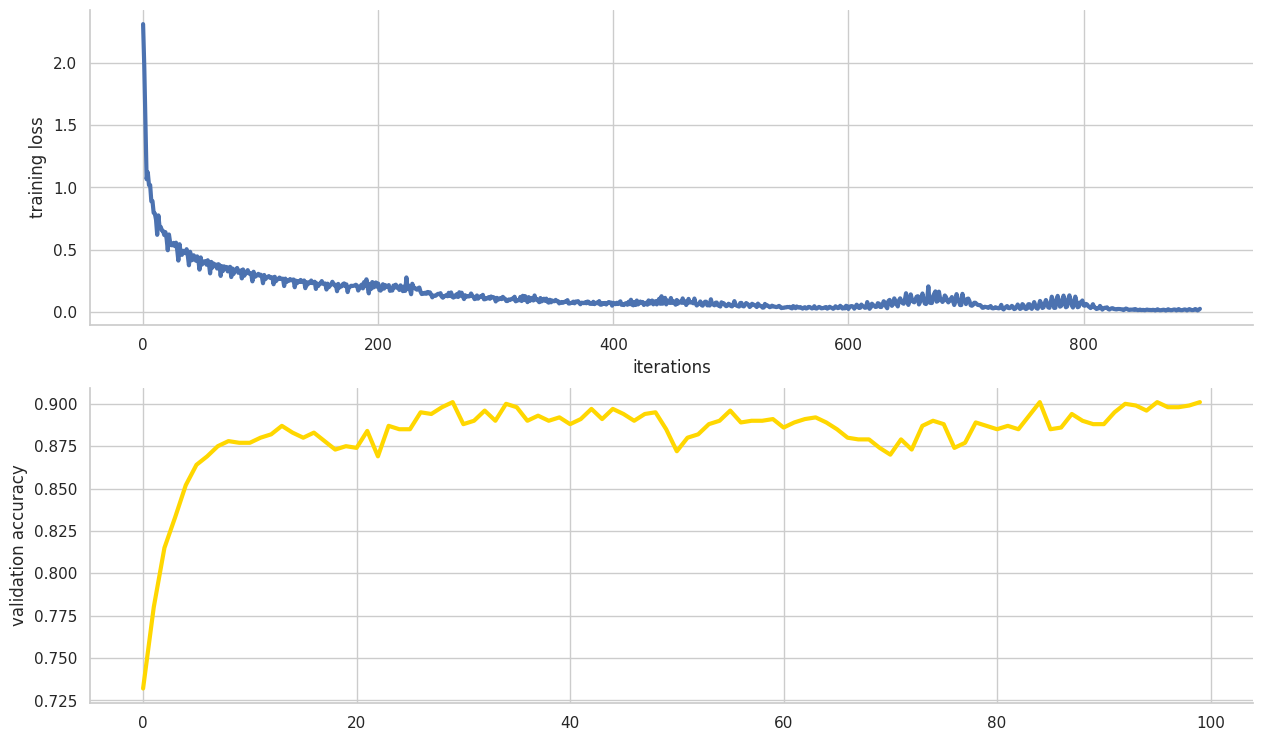

In [912]:
# Visualize training loss

plt.figure(figsize = (15, 9))

plt.subplot(2, 1, 1)
plt.plot(train_loss_list, linewidth = 3)
plt.ylabel("training loss")
plt.xlabel("iterations")
sns.despine()

plt.subplot(2, 1, 2)
plt.plot(validation_accuracy_list, linewidth = 3, color = 'gold')
plt.ylabel("validation accuracy")
sns.despine()

In [913]:
# Compute the testing accuracy 

with torch.no_grad():        
  test_outputs = model(test_inputs)
    
  correct = (torch.argmax(test_outputs, dim=1) == test_targets).type(torch.FloatTensor).to(device)
    
  test_accuracy = correct.mean().item()
  print('Testingaccuracy: {:.4f}'.format(test_accuracy))

Testingaccuracy: 0.8940


In [914]:
# (OPTIONAL) Print the testing accuracy for each fashion class. Your code should produce something that looks like:
# Clever usage of np.where() could be useful here
# "Accuracy of T-shirt/top: 93.5 %"
# "Accuracy of Trouser: 89.3 %"
# etc...
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
accuracy=[]
for i in range(10):
  index = np.where(test_targets.cpu().numpy()==i)[0]
  class_correct = (torch.argmax(test_outputs[index], dim=1) == i).type(torch.FloatTensor).to(device)
  accuracy.append(class_correct.mean().item())
  print('Accuracy of {}: {:.2f}%'.format(class_names[i], accuracy[i] * 100))
# What's the fashion item that your model had the hardest time classifying?
ind = np.argmin(accuracy)
print('Whats the fashion item that your model had the hardest time classifying:{}'.format(class_names[ind]))

Accuracy of T-shirt/top: 90.65%
Accuracy of Trouser: 97.14%
Accuracy of Pullover: 80.18%
Accuracy of Dress: 83.87%
Accuracy of Coat: 87.83%
Accuracy of Sandal: 96.55%
Accuracy of Shirt: 68.04%
Accuracy of Sneaker: 98.95%
Accuracy of Bag: 96.84%
Accuracy of Ankle boot: 95.79%
Whats the fashion item that your model had the hardest time classifying:Shirt
